In [2]:
import osgeo
from osgeo import gdal
import matplotlib.pyplot as plt
import h5py
import numpy as np

import matplotlib
matplotlib.use('qt5agg')

gdal.UseExceptions()

In [3]:
def read_img(path : str) -> None:
    dataset = gdal.Open(path)

    print(f"Size: {dataset.RasterXSize,dataset.RasterYSize,dataset.RasterCount}")
    print(f"GeoTransform: {dataset.GetGeoTransform()}")
    print(f"CRS: {dataset.GetSpatialRef()}")
    print(f"Projection: {dataset.GetProjection()}")

    band9 = dataset.GetRasterBand(9)

    # f,ax = plt.subplots(1,1)
    # ax.set_yticks([]); ax.set_xticks([])
    # ax.imshow(band9.ReadAsArray())

read_img("C:/Lunar_Imagery_Data/MI_data/MI_MAP_03_N37E319N36E320SC.lbl")
# read_img("C:/Lunar_Imagery_Data/gruithuisen_m3target_L2/020644/m3t20090418t020644_v01_rfl.img")

Size: (2048, 2048, 9)
GeoTransform: (-1243264.7701914825, 14.806323445, 0.0, 1121971.3685300425, 0.0, -14.806323445)
CRS: PROJCS["SIMPLE_CYLINDRICAL MOON",
    GEOGCS["GCS_MOON",
        DATUM["D_MOON",
            SPHEROID["MOON",1737400,0]],
        PRIMEM["Reference_Meridian",0],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]]],
    PROJECTION["Equirectangular"],
    PARAMETER["standard_parallel_1",0],
    PARAMETER["central_meridian",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]
Projection: PROJCS["SIMPLE_CYLINDRICAL MOON",GEOGCS["GCS_MOON",DATUM["D_MOON",SPHEROID["MOON",1737400,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_nort

In [158]:
data = np.zeros([0,584,408])
with h5py.File("targeted.hdf5") as f:
    for ds in f["Backplanes"].keys():
        print(ds)    
        dat = f[f"Backplanes/{ds}"]
        if dat.shape[-1] < 20:
            dat = np.moveaxis(dat,2,0)
        data = np.concatenate([data,dat])

    # data = f["VectorDatasets/SmoothSpectra_GNDTRU"][:,:,:]
    # wavelengths = f.attrs["smooth_wavelengths"]

desc = ["Lon","Lat","Elev","X","Y","To-Sun AZM","To-Sun Zenith","To-Inst AZM","To-Inst Zenith","Phase-angle","To-Sun Path Length","To-Inst Path Length","Facet Slope","Facet Aspect","Facet Cos i"]
refds = gdal.Open("C:/Lunar_Imagery_Data/MI_data/MI_MAP_03_N34E318N33E319SC.lbl")
sref = refds.GetSpatialRef()
refds.Close()

#eType=7 means Float64
with gdal.GetDriverByName('ENVI').Create('M3geometry.img',data.shape[2],data.shape[1],data.shape[0],eType=7) as ds:
    ds.WriteArray(data[:,::-1,:])
    ds.SetSpatialRef(sref)
    ds.SetGeoTransform(geotransform)
    
    for i in range(1,data.shape[0]+1,1):
        rb = ds.GetRasterBand(i)
        rb.SetDescription(f"{desc[i-1]}")

# with open('test.hdr',"a") as f:
#     f.write('wavelength units = um\n')
#     f.write(f'wavelength = {{{",".join(wavelengths.astype(str))}}}')

        

LatLongElev
LatLongProjected
ObsGeometry


In [161]:
# data = np.zeros([0,584,408])
with h5py.File("targeted.hdf5") as f:
    # for ds in f["Backplanes"].keys():
    #     print(ds)    
    #     dat = f[f"Backplanes/{ds}"]
    #     if dat.shape[-1] < 20:
    #         dat = np.moveaxis(dat,2,0)
    #     data = np.concatenate([data,dat])

    data = f["VectorDatasets/SmoothSpectra_GNDTRU"][:,:,:]
    wavelengths = f.attrs["smooth_wavelengths"]

# desc = ["Lon","Lat","Elev","X","Y","To-Sun AZM","To-Sun Zenith","To-Inst AZM","To-Inst Zenith","Phase-angle","To-Sun Path Length","To-Inst Path Length","Facet Slope","Facet Aspect","Facet Cos i"]
refds = gdal.Open("C:/Lunar_Imagery_Data/MI_data/MI_MAP_03_N34E318N33E319SC.lbl")
sref = refds.GetSpatialRef()
refds.Close()

#eType=7 means Float64
with gdal.GetDriverByName('ENVI').Create('M3_RFL.img',data.shape[2],data.shape[1],data.shape[0],eType=7) as ds:
    ds.WriteArray(data[:,::-1,:])
    ds.SetSpatialRef(sref)
    ds.SetGeoTransform(geotransform)
    
    for i in range(1,data.shape[0]+1,1):
        rb = ds.GetRasterBand(i)
        rb.SetDescription(f"{wavelengths[i-1]}")

with open('test.hdr',"a") as f:
    f.write('wavelength units = um\n')
    f.write(f'wavelength = {{{",".join(wavelengths.astype(str))}}}')

In [159]:
with h5py.File('proj_latlong.hdf5') as f:
    dat = f["Backplanes/LatLongProjected"][:,:,:]

with h5py.File('targeted.hdf5') as f:
    chk = f["Backplanes/LatLongElev"][:,:,:]

def eucdistance(x1,y1,x2,y2):
    return np.sqrt((y2-y1)**2+(x2-x1)**2)

xres = eucdistance(*dat[0,0,:],*dat[-1,0,:]) / dat.shape[0]
yres = eucdistance(*dat[0,0,:],*dat[0,-1,:]) / dat.shape[1]

geotransform = (dat[-1,0,0]-(xres/2.),xres,0,dat[-1,0,1]- (yres/2.),0,-yres)

print(geotransform)
print(chk[:,-1,0])
print(xres,yres)
print(chk[:,-1,-1])


(-1253298.6341265375, 79.01620637819542, 0, 1131671.75377189, 0, -82.36874172386013)
[3.18670163e+02 3.73215005e+01 1.73564695e+06]
79.01620637819542 82.36874172386013
[3.19798655e+02 3.72974330e+01 1.73533235e+06]


In [69]:
import pandas as pd
pts = pd.read_csv('./control_pts.txt',delimiter='\t',header=None)
arr = pts.to_numpy()

with h5py.File("proj_latlong.hdf5","r") as f:
    xy = f["Backplanes/LatLongProjected"][:,:,:]


print(arr)
print("Minimums: ",xy[583,0])
print("xMax: ", xy[0,0])
print("yMax: ", xy[0,407])

# print(xy.shape)

plt.imshow(xy[:,:,1])

# print(arr)

qgis_arr = np.zeros((12,4))
for i in range(arr.shape[0]):
    xdiff = xy[0,-1,0]-xy[0,0,0]
    ydiff = xy[-1,0,1]-xy[0,0,1]
    x_og = xy.shape[1]*(xy[0,-1,0]-arr[i,2])/xdiff
    y_og = xy.shape[0]*(xy[-1,0,1]-arr[i,3])/ydiff
    x_new = xy.shape[1]*(xy[0,-1,0]-arr[i,0])/xdiff
    y_new = xy.shape[0]*(xy[-1,0,1]-arr[i,1])/ydiff
    plt.scatter(x_og,y_og,c='red')
    plt.scatter(x_new,y_new,c="blue")

    qgis_arr[i,:] = [arr[i,2],arr[i,3],arr[i,0],arr[i,1]]
plt.show()

with open("qgis_gcps.points","w") as f:
    f.write("mapX,mapY,pixelX,pixelY,enable\n")
    for i in range(qgis_arr.shape[0]):
        f.write(f"{qgis_arr[i,0]},{qgis_arr[i,1]},{qgis_arr[i,2]},{qgis_arr[i,3]},1\n")


[[-1222387.95742   1108834.414807 -1219391.180618  1108928.907769]
 [-1232471.70639   1107444.018362 -1230568.34815   1108064.972114]
 [-1232990.191786  1089658.105619 -1230834.109607  1091035.146733]
 [-1241034.087167  1121684.060598 -1239531.680568  1122036.43153 ]
 [-1241936.56511   1121663.032826 -1240517.107174  1121995.934546]
 [-1232369.529232  1128990.396605 -1230554.849156  1128866.9228  ]
 [-1233830.328454  1113345.667922 -1232093.734541  1113775.046832]
 [-1247672.098166  1103653.61312  -1246168.12379   1104681.786591]
 [-1242682.990922  1110533.170811 -1241095.404103  1111314.990055]
 [-1252345.912958  1108889.958379 -1251160.25448   1109682.151668]
 [-1249453.310575  1087967.546412 -1247794.015595  1089648.174984]
 [-1239969.531997  1092068.850447 -1237941.00224   1093524.135905]]
Minimums:  [-1253259.12602335  1131712.93814275]
xMax:  [-1252280.83825218  1085577.84467528]
yMax:  [-1218682.38940947  1084844.70757282]


In [206]:
with gdal.Open('G:/My Drive/outreach_materials/Crater Activity/faulted_crater.tif') as ds:
    arr = ds.ReadAsArray()

In [207]:
arr.shape

(91209, 5539)

(1300, 1000)


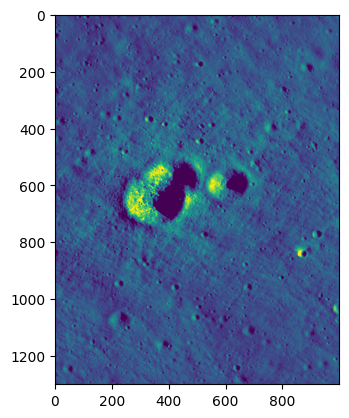

In [216]:
import matplotlib.pyplot as plt

arr_cropped = arr[65200:66500,1900:2900]
plt.imshow(arr_cropped)
print(arr_cropped.shape)

with gdal.GetDriverByName('GTiff').Create('G:/My Drive/outreach_materials/Crater Activity/faulted_crater_cropped.tif',1000,1300) as ds:
    ds.WriteArray(arr_cropped)


In [98]:
with open('C:/Lunar_Imagery_Data/MI_data/MI_MAP_03_N37E319N36E320SC.lbl') as f:
    for i in f.readlines():
        if i.find('WAVELENGTH') > 0:
            i

CENTER_FILTER_WAVELENGTH             = (414.0 <nm>, 749.0 <nm>, 901.0 <nm>, 950.0 <nm>, 1001.0 <nm>, 1000.0 <nm>, 1049.0 <nm>, 1248.0 <nm>, 1548.0 <nm>)



In [112]:
with h5py.File('targeted.hdf5') as h:
    wvl = np.array(h.attrs["smooth_wavelengths"])

print(np.argmin(abs(wvl-749)))

18


In [114]:
with gdal.Open('./M3_RFL_georef.tif') as ds:
    spref = ds.GetSpatialRef()
    geotrans = ds.GetGeoTransform()

with gdal.open('./M3_single_band.tif') as ds: